휴폐업 중소기업 예측모델


In [ ]:
# plot 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 코드 실행후 런타임 다시 시작 해야함

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
# 필요한패키지 import

import pandas as pd
import numpy as np
import xgboost as xgb
!pip install unidecode
import unidecode
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 드라이브에서 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
finance = pd.read_csv('/content/drive/MyDrive/휴페업데이터/finance_4.csv', encoding = 'euc-kr')
print(finance)

       Unnamed: 0       사업자번호          유동자산        매출채권         비유동자산  \
0               1  1018100340  2.070964e+06   143384.75  3.549089e+07   
1               2  1018100772  4.828732e+05         NaN  2.089307e+07   
2               3  1018101126  1.491190e+06   102136.25  3.550742e+07   
3               4  1018101242  5.428135e+05   144011.75  2.465907e+07   
4               5  1018103819  1.667547e+06    48041.25  1.150967e+07   
...           ...         ...           ...         ...           ...   
35704       35705  8998700283  1.008218e+06   494015.00  2.950450e+05   
35705       35706  8998701263  9.025398e+06         NaN           NaN   
35706       35707  8998800150  8.987382e+06  1454567.25  2.287665e+07   
35707       35708  8998800427  7.198705e+06  2728476.25  7.227014e+06   
35708       35709  8998800785  2.024726e+06         NaN  3.424973e+08   

               유형자산          자산총계          유동부채         비유동부채    부..채..총..계  \
0      1.118161e+06  3.756186e+07  5.333542e

In [ ]:
# 결측치 채우기
finance = finance.fillna(0)
print(finance)

       Unnamed: 0       사업자번호          유동자산        매출채권         비유동자산  \
0               1  1018100340  2.070964e+06   143384.75  3.549089e+07   
1               2  1018100772  4.828732e+05        0.00  2.089307e+07   
2               3  1018101126  1.491190e+06   102136.25  3.550742e+07   
3               4  1018101242  5.428135e+05   144011.75  2.465907e+07   
4               5  1018103819  1.667547e+06    48041.25  1.150967e+07   
...           ...         ...           ...         ...           ...   
35704       35705  8998700283  1.008218e+06   494015.00  2.950450e+05   
35705       35706  8998701263  9.025398e+06        0.00  0.000000e+00   
35706       35707  8998800150  8.987382e+06  1454567.25  2.287665e+07   
35707       35708  8998800427  7.198705e+06  2728476.25  7.227014e+06   
35708       35709  8998800785  2.024726e+06        0.00  3.424973e+08   

               유형자산          자산총계          유동부채         비유동부채    부..채..총..계  \
0      1.118161e+06  3.756186e+07  5.333542e

In [ ]:
# unnamed 열(기존의 index) 삭제하기
finance = finance.drop([finance.columns[0]],axis=1)
print(finance)

            사업자번호          유동자산        매출채권         비유동자산          유형자산  \
0      1018100340  2.070964e+06   143384.75  3.549089e+07  1.118161e+06   
1      1018100772  4.828732e+05        0.00  2.089307e+07  2.088182e+07   
2      1018101126  1.491190e+06   102136.25  3.550742e+07  3.435322e+07   
3      1018101242  5.428135e+05   144011.75  2.465907e+07  2.200939e+07   
4      1018103819  1.667547e+06    48041.25  1.150967e+07  1.108649e+07   
...           ...           ...         ...           ...           ...   
35704  8998700283  1.008218e+06   494015.00  2.950450e+05  2.750500e+04   
35705  8998701263  9.025398e+06        0.00  0.000000e+00  0.000000e+00   
35706  8998800150  8.987382e+06  1454567.25  2.287665e+07  1.850289e+07   
35707  8998800427  7.198705e+06  2728476.25  7.227014e+06  6.594312e+06   
35708  8998800785  2.024726e+06        0.00  3.424973e+08  3.419077e+08   

               자산총계          유동부채         비유동부채    부..채..총..계         자본금  \
0      3.756186e+07  5

In [ ]:
# 사업자번호 삭제한 df를 finance_x로 선언하고, 독립변수 X로 설정하기
finance_x = finance.drop([finance.columns[0]],axis=1)
X= finance_x.iloc[:,:-1].copy()
X.head()

,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부..채..총..계,자본금,이익잉여금.결손금.,...,법인세비용차감전순손익,법인세비용,당기순이익.손실.,기업순이익률...,유보액.총자산...,유보액.납입자본...,매출액총이익률...,매출액영업이익률...,매출액순이익률...,수지비율...
0,2070964.50,143384.75,35490892.00,1118160.75,37561856.5,5333541.50,10453503.00,15787044.25,721100.0,4241783.75,...,3875643.25,757435.25,3118208.25,8.07725,5.54400,289.89750,100.00000,6.66200,49.78750,60.74800
1,482873.25,0.00,20893071.75,20881821.75,21375945.0,3142721.25,12042743.75,15185465.00,52000.0,-7922319.25,...,-333442.75,0.00,-333442.75,-0.42500,-33.70475,-13863.74900,24.88600,-51.69050,-76.48600,161.47975
2,1491190.25,102136.25,35507416.50,34353222.50,36998607.0,8974535.25,3180149.00,12154684.00,1539640.0,-3495725.25,...,-353066.50,0.00,-353066.50,-0.26475,-1.61025,-37.91700,41.57100,1.12175,-14.42625,115.17975
3,542813.50,144011.75,24659065.25,22009393.00,25201879.0,6706615.00,2318500.00,9025115.00,450000.0,19692191.25,...,509955.75,97755.50,412200.25,2.43100,86.47050,4841.92225,55.97575,22.04450,14.09375,83.30700
4,1667547.00,48041.25,11509672.25,11086486.50,13177218.5,6715410.00,1568217.75,8283628.00,500000.0,4383956.50,...,440965.25,86017.50,354947.25,3.34275,32.50525,856.78850,100.00000,42.72100,32.39725,61.96825


,유동자산,매출채권,비유동자산,유형자산,자산총계,유동부채,비유동부채,부..채..총..계,자본금,이익잉여금.결손금.,...,법인세비용차감전순손익,법인세비용,당기순이익.손실.,기업순이익률...,유보액.총자산...,유보액.납입자본...,매출액총이익률...,매출액영업이익률...,매출액순이익률...,수지비율...
0,2070964.50,143384.75,35490892.00,1118160.75,37561856.5,5333541.50,10453503.00,15787044.25,721100.0,4241783.75,...,3875643.25,757435.25,3118208.25,8.07725,5.54400,289.89750,100.00000,6.66200,49.78750,60.74800
1,482873.25,0.00,20893071.75,20881821.75,21375945.0,3142721.25,12042743.75,15185465.00,52000.0,-7922319.25,...,-333442.75,0.00,-333442.75,-0.42500,-33.70475,-13863.74900,24.88600,-51.69050,-76.48600,161.47975
2,1491190.25,102136.25,35507416.50,34353222.50,36998607.0,8974535.25,3180149.00,12154684.00,1539640.0,-3495725.25,...,-353066.50,0.00,-353066.50,-0.26475,-1.61025,-37.91700,41.57100,1.12175,-14.42625,115.17975
3,542813.50,144011.75,24659065.25,22009393.00,25201879.0,6706615.00,2318500.00,9025115.00,450000.0,19692191.25,...,509955.75,97755.50,412200.25,2.43100,86.47050,4841.92225,55.97575,22.04450,14.09375,83.30700
4,1667547.00,48041.25,11509672.25,11086486.50,13177218.5,6715410.00,1568217.75,8283628.00,500000.0,4383956.50,...,440965.25,86017.50,354947.25,3.34275,32.50525,856.78850,100.00000,42.72100,32.39725,61.96825


In [ ]:
# 폐업 여부를 종속변수 y 선언하기
y = finance['newcol'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: newcol, dtype: int64

0    0
1    0
2    0
3    0
4    0
Name: newcol, dtype: int64

In [ ]:
sum(y)/len(y)
# 폐업비율이 약 19%라는것을 알 수 있음

0.18849589739281414

0.18849589739281414

In [ ]:
# x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
sum(y_train)/len(y_train)
# 값이 0.188이 나오면 맞게 나누어진것

0.18849184123072327

0.18849184123072327

In [ ]:
# XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.774255
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.775591
[2]	validation_0-aucpr:0.787744
[3]	validation_0-aucpr:0.790404
[4]	validation_0-aucpr:0.790504
[5]	validation_0-aucpr:0.797647
[6]	validation_0-aucpr:0.798383
[7]	validation_0-aucpr:0.804834
[8]	validation_0-aucpr:0.804008
[9]	validation_0-aucpr:0.806406
[10]	validation_0-aucpr:0.805725
[11]	validation_0-aucpr:0.807224
[12]	validation_0-aucpr:0.807855
[13]	validation_0-aucpr:0.813705
[14]	validation_0-aucpr:0.814629
[15]	validation_0-aucpr:0.817116
[16]	validation_0-aucpr:0.817207
[17]	validation_0-aucpr:0.817693
[18]	validation_0-aucpr:0.817353
[19]	validation_0-aucpr:0.818458
[20]	validation_0-aucpr:0.819608
[21]	validation_0-aucpr:0.818384
[22]	validation_0-aucpr:0.819575
[23]	validation_0-aucpr:0.821485
[24]	validation_0-aucpr:0.820961
[25]	validation_0-aucpr:0.821508
[26]	validation_0-aucpr:0.822603
[27]	validation_0-aucpr:0.824073
[28]	validation_0-au

XGBClassifier()

[0]	validation_0-aucpr:0.759846
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.774443
[2]	validation_0-aucpr:0.777735
[3]	validation_0-aucpr:0.790797
[4]	validation_0-aucpr:0.801985
[5]	validation_0-aucpr:0.802176
[6]	validation_0-aucpr:0.802355
[7]	validation_0-aucpr:0.803059
[8]	validation_0-aucpr:0.804094
[9]	validation_0-aucpr:0.809551
[10]	validation_0-aucpr:0.812075
[11]	validation_0-aucpr:0.813947
[12]	validation_0-aucpr:0.816223
[13]	validation_0-aucpr:0.816675
[14]	validation_0-aucpr:0.817929
[15]	validation_0-aucpr:0.819013
[16]	validation_0-aucpr:0.819665
[17]	validation_0-aucpr:0.820352
[18]	validation_0-aucpr:0.81966
[19]	validation_0-aucpr:0.820061
[20]	validation_0-aucpr:0.820945
[21]	validation_0-aucpr:0.821774
[22]	validation_0-aucpr:0.823017
[23]	validation_0-aucpr:0.824232
[24]	validation_0-aucpr:0.826188
[25]	validation_0-aucpr:0.823692
[26]	validation_0-aucpr:0.825091
[27]	validation_0-aucpr:0.827425
[28]	validation_0-auc

XGBClassifier()

1번째 시작한 트리에서는 AUC가 0.77가 나왔으나, 100번째 트리 시도에서는 AUC가 0.862까지 개선된 결과를 보여준다.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


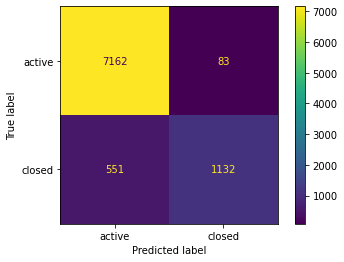

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


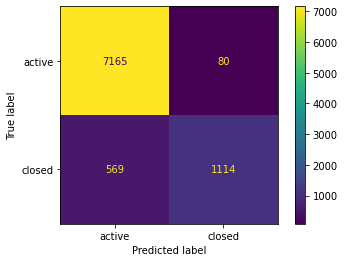

In [ ]:
# 모델에 대한 성능평가를 위한 혼동행렬완성하기
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
# 성능평가 결과값
y_pred_probs = clf_xgb.predict(X_test)

In [ ]:
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

[[7162   83]
 [ 551 1132]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7245
           1       0.93      0.67      0.78      1683

    accuracy                           0.93      8928
   macro avg       0.93      0.83      0.87      8928
weighted avg       0.93      0.93      0.92      8928

0.8305761303203758
[[7165   80]
 [ 569 1114]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7245
           1       0.93      0.66      0.77      1683

    accuracy                           0.93      8928
   macro avg       0.93      0.83      0.87      8928
weighted avg       0.93      0.93      0.92      8928

0.8254355760749622


In [ ]:
# plot label 한국어로 설정하기
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_

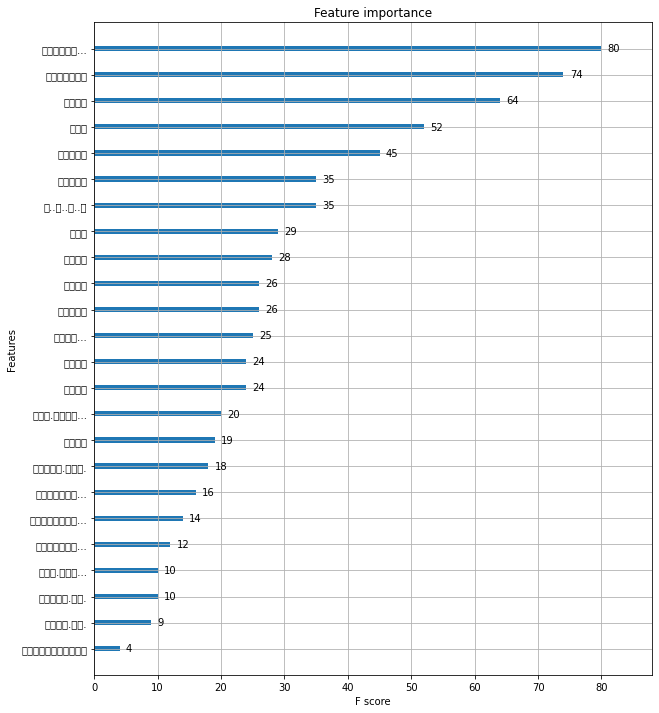

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49692 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_

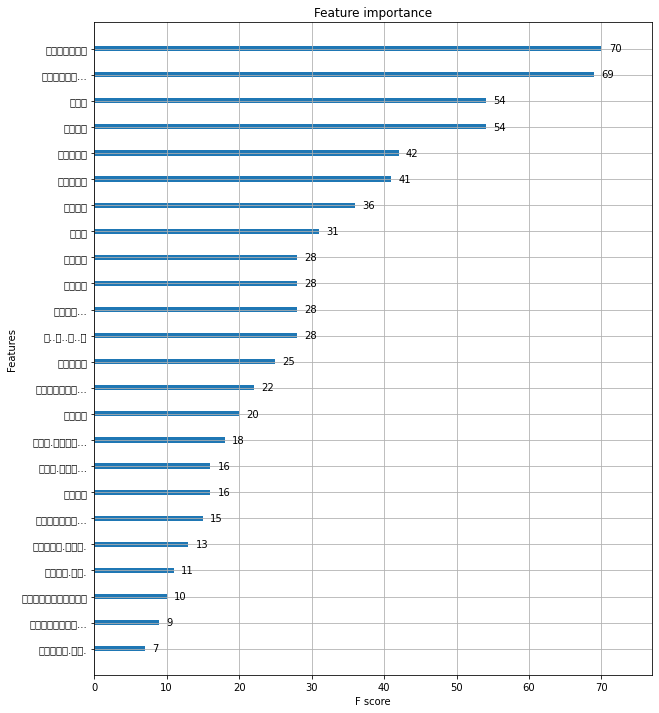

In [ ]:
# feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

# 모델 2

In [ ]:
# 5년 기준으로 폐업 여부 xgboost 예측모델 만들어보기
# 5년 이상 영업한 기업의 경우 long 컬럼에 1, 5년 이하의 경우 0으로 표시 
# feature importance가 가장 높았던 자산총계도 함께 이용할 예정
finance_5y = pd.read_csv('/content/drive/MyDrive/휴페업데이터/finance_5years.csv', encoding = 'euc-kr')
print(finance_5y)

       Unnamed: 0      BIZ_NO          자산총계  operation_date  EMP_CNT  long  \
0               1  1018100340  3.756186e+07         24049.0     41.0   1.0   
1               2  1018100772  2.137594e+07         19341.0      3.0   1.0   
2               3  1018101126  3.699861e+07         20040.0     13.0   1.0   
3               4  1018101242  2.520188e+07         18942.0     17.0   1.0   
4               5  1018103819  1.317722e+07         18946.0      4.0   1.0   
...           ...         ...           ...             ...      ...   ...   
35797       35798  8998700283  1.303263e+06          2147.0      5.0   1.0   
35798       35799  8998701263  9.025398e+06          1172.0      2.0   0.0   
35799       35800  8998800150  3.186404e+07          3962.0    106.0   1.0   
35800       35801  8998800427  1.442572e+07          2283.0     59.0   1.0   
35801       35802  8998800785  3.445220e+08          1841.0      0.0   1.0   

       new_col  
0            0  
1            0  
2           

In [ ]:
#결측치 채우기
finance_5y = finance_5y.fillna(0)
print(finance_5y)

       Unnamed: 0      BIZ_NO          자산총계  operation_date  EMP_CNT  long  \
0               1  1018100340  3.756186e+07         24049.0     41.0   1.0   
1               2  1018100772  2.137594e+07         19341.0      3.0   1.0   
2               3  1018101126  3.699861e+07         20040.0     13.0   1.0   
3               4  1018101242  2.520188e+07         18942.0     17.0   1.0   
4               5  1018103819  1.317722e+07         18946.0      4.0   1.0   
...           ...         ...           ...             ...      ...   ...   
35797       35798  8998700283  1.303263e+06          2147.0      5.0   1.0   
35798       35799  8998701263  9.025398e+06          1172.0      2.0   0.0   
35799       35800  8998800150  3.186404e+07          3962.0    106.0   1.0   
35800       35801  8998800427  1.442572e+07          2283.0     59.0   1.0   
35801       35802  8998800785  3.445220e+08          1841.0      0.0   1.0   

       new_col  
0            0  
1            0  
2           

In [ ]:
#unnamed 열 삭제하기
finance_5y = finance_5y.drop([finance_5y.columns[0]], axis=1)
print(finance_5y)

           BIZ_NO          자산총계  operation_date  EMP_CNT  long  new_col
0      1018100340  3.756186e+07         24049.0     41.0   1.0        0
1      1018100772  2.137594e+07         19341.0      3.0   1.0        0
2      1018101126  3.699861e+07         20040.0     13.0   1.0        0
3      1018101242  2.520188e+07         18942.0     17.0   1.0        0
4      1018103819  1.317722e+07         18946.0      4.0   1.0        0
...           ...           ...             ...      ...   ...      ...
35797  8998700283  1.303263e+06          2147.0      5.0   1.0        1
35798  8998701263  9.025398e+06          1172.0      2.0   0.0        1
35799  8998800150  3.186404e+07          3962.0    106.0   1.0        0
35800  8998800427  1.442572e+07          2283.0     59.0   1.0        0
35801  8998800785  3.445220e+08          1841.0      0.0   1.0        0

[35802 rows x 6 columns]
           BIZ_NO          자산총계  operation_date  EMP_CNT  long  new_col
0      1018100340  3.756186e+07       

In [ ]:
# 먼저 비재무적 데이터만을 뽑아서 XGboost 돌려보기
finance_5y_copy = finance_5y.drop(['자산총계','BIZ_NO'], axis=1).copy()
print(finance_5y_copy)


       operation_date  EMP_CNT  long  new_col
0             24049.0     41.0   1.0        0
1             19341.0      3.0   1.0        0
2             20040.0     13.0   1.0        0
3             18942.0     17.0   1.0        0
4             18946.0      4.0   1.0        0
...               ...      ...   ...      ...
35797          2147.0      5.0   1.0        1
35798          1172.0      2.0   0.0        1
35799          3962.0    106.0   1.0        0
35800          2283.0     59.0   1.0        0
35801          1841.0      0.0   1.0        0

[35802 rows x 4 columns]
       operation_date  EMP_CNT  long  new_col
0             24049.0     41.0   1.0        0
1             19341.0      3.0   1.0        0
2             20040.0     13.0   1.0        0
3             18942.0     17.0   1.0        0
4             18946.0      4.0   1.0        0
...               ...      ...   ...      ...
35797          2147.0      5.0   1.0        1
35798          1172.0      2.0   0.0        1
35799   

In [ ]:
# finance_5y에서 new_col을 제외한 변수를 독립변수 X로 설정
X = finance_5y_copy.iloc[:,:-1].copy()
X.head()

,operation_date,EMP_CNT,long
0,24049.0,41.0,1.0
1,19341.0,3.0,1.0
2,20040.0,13.0,1.0
3,18942.0,17.0,1.0
4,18946.0,4.0,1.0


,operation_date,EMP_CNT,long
0,24049.0,41.0,1.0
1,19341.0,3.0,1.0
2,20040.0,13.0,1.0
3,18942.0,17.0,1.0
4,18946.0,4.0,1.0


In [ ]:
# 폐업 여부를 종속변수 y 선언하기
y = finance_5y_copy['new_col'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: new_col, dtype: int64

0    0
1    0
2    0
3    0
4    0
Name: new_col, dtype: int64

In [ ]:
sum(y)/len(y)
# 이번에는 폐업 데이터가 전체의 0.19 차지

0.19060387687838667

0.19060387687838667

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

sum(y_train)/len(y_train)

0.1906074261666232

0.1906074261666232

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.372322
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.373423
[2]	validation_0-aucpr:0.374885
[3]	validation_0-aucpr:0.3761
[4]	validation_0-aucpr:0.385804
[5]	validation_0-aucpr:0.385851
[6]	validation_0-aucpr:0.38874
[7]	validation_0-aucpr:0.388788
[8]	validation_0-aucpr:0.389202
[9]	validation_0-aucpr:0.394547
[10]	validation_0-aucpr:0.397942
[11]	validation_0-aucpr:0.398174
[12]	validation_0-aucpr:0.398003
[13]	validation_0-aucpr:0.398088
[14]	validation_0-aucpr:0.398362
[15]	validation_0-aucpr:0.398766
[16]	validation_0-aucpr:0.399015
[17]	validation_0-aucpr:0.398933
[18]	validation_0-aucpr:0.3994
[19]	validation_0-aucpr:0.399949
[20]	validation_0-aucpr:0.399741
[21]	validation_0-aucpr:0.399781
[22]	validation_0-aucpr:0.399918
[23]	validation_0-aucpr:0.400134
[24]	validation_0-aucpr:0.401606
[25]	validation_0-aucpr:0.401673
[26]	validation_0-aucpr:0.402854
[27]	validation_0-aucpr:0.402646
[28]	validation_0-aucpr:0

XGBClassifier()

[0]	validation_0-aucpr:0.375352
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.376317
[2]	validation_0-aucpr:0.377165
[3]	validation_0-aucpr:0.378052
[4]	validation_0-aucpr:0.381558
[5]	validation_0-aucpr:0.391837
[6]	validation_0-aucpr:0.392174
[7]	validation_0-aucpr:0.392256
[8]	validation_0-aucpr:0.398834
[9]	validation_0-aucpr:0.399125
[10]	validation_0-aucpr:0.401609
[11]	validation_0-aucpr:0.402443
[12]	validation_0-aucpr:0.401883
[13]	validation_0-aucpr:0.402215
[14]	validation_0-aucpr:0.402844
[15]	validation_0-aucpr:0.40494
[16]	validation_0-aucpr:0.40362
[17]	validation_0-aucpr:0.405352
[18]	validation_0-aucpr:0.40372
[19]	validation_0-aucpr:0.40556
[20]	validation_0-aucpr:0.406209
[21]	validation_0-aucpr:0.405657
[22]	validation_0-aucpr:0.405605
[23]	validation_0-aucpr:0.405927
[24]	validation_0-aucpr:0.406063
[25]	validation_0-aucpr:0.406158
[26]	validation_0-aucpr:0.407204
[27]	validation_0-aucpr:0.40732
[28]	validation_0-aucpr:0

XGBClassifier()

실행값결과 AUC값이 0.42로 너무 작아 비재무적 요인 단독으로는 사용할 수 없을것 같다. 재무적 요인과 같이 결합해서 사용해보자.





In [ ]:
# 이번에는 feature importance가 가장 높았던 자산총계도 함께 이용해보자
# 사업자번호 삭제하고 독립변수 X로 설정하기
finance_5y = finance_5y.drop(['BIZ_NO'],axis=1)
X = finance_5y.iloc[:,:-1].copy()
X.head()


,자산총계,operation_date,EMP_CNT,long
0,37561856.5,24049.0,41.0,1.0
1,21375945.0,19341.0,3.0,1.0
2,36998607.0,20040.0,13.0,1.0
3,25201879.0,18942.0,17.0,1.0
4,13177218.5,18946.0,4.0,1.0


,자산총계,operation_date,EMP_CNT,long
0,37561856.5,24049.0,41.0,1.0
1,21375945.0,19341.0,3.0,1.0
2,36998607.0,20040.0,13.0,1.0
3,25201879.0,18942.0,17.0,1.0
4,13177218.5,18946.0,4.0,1.0


In [ ]:
#폐업 여부를 종속변수 y 선언하기
y = finance_5y['new_col'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: new_col, dtype: int64

0    0
1    0
2    0
3    0
4    0
Name: new_col, dtype: int64

In [ ]:
#x,y 변수를 train 과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
#XGboost 모델 구축하기
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

# binary:logistic -> 이진분류를 위한 로지스틱 회귀, 클래스가 아닌 예측 확률 반환
# eval_metric[목적함수에 따라 default가 다름 회귀-rmse/ 분류-error]
# early_stopping_rounds : 최대한 몇 개의 트리를 완성할 것인지 valid loss에 더이상 진전이 없다면 멈춘다. n_estimators가 높을 때 주로 사용하며 과적합을 방지해준다.

[0]	validation_0-aucpr:0.768557
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.769819
[2]	validation_0-aucpr:0.770817
[3]	validation_0-aucpr:0.780388
[4]	validation_0-aucpr:0.78718
[5]	validation_0-aucpr:0.789265
[6]	validation_0-aucpr:0.796804
[7]	validation_0-aucpr:0.801636
[8]	validation_0-aucpr:0.802028
[9]	validation_0-aucpr:0.802403
[10]	validation_0-aucpr:0.803641
[11]	validation_0-aucpr:0.80452
[12]	validation_0-aucpr:0.80738
[13]	validation_0-aucpr:0.808978
[14]	validation_0-aucpr:0.810139
[15]	validation_0-aucpr:0.813185
[16]	validation_0-aucpr:0.813476
[17]	validation_0-aucpr:0.816628
[18]	validation_0-aucpr:0.817291
[19]	validation_0-aucpr:0.818735
[20]	validation_0-aucpr:0.818198
[21]	validation_0-aucpr:0.818677
[22]	validation_0-aucpr:0.818545
[23]	validation_0-aucpr:0.818713
[24]	validation_0-aucpr:0.818971
[25]	validation_0-aucpr:0.821625
[26]	validation_0-aucpr:0.821902
[27]	validation_0-aucpr:0.822321
[28]	validation_0-aucpr

XGBClassifier()

[0]	validation_0-aucpr:0.7706
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.774889
[2]	validation_0-aucpr:0.782877
[3]	validation_0-aucpr:0.792121
[4]	validation_0-aucpr:0.793988
[5]	validation_0-aucpr:0.799784
[6]	validation_0-aucpr:0.806477
[7]	validation_0-aucpr:0.806823
[8]	validation_0-aucpr:0.807368
[9]	validation_0-aucpr:0.809263
[10]	validation_0-aucpr:0.809861
[11]	validation_0-aucpr:0.809627
[12]	validation_0-aucpr:0.810507
[13]	validation_0-aucpr:0.815936
[14]	validation_0-aucpr:0.816828
[15]	validation_0-aucpr:0.817927
[16]	validation_0-aucpr:0.818501
[17]	validation_0-aucpr:0.819505
[18]	validation_0-aucpr:0.819635
[19]	validation_0-aucpr:0.825573
[20]	validation_0-aucpr:0.825583
[21]	validation_0-aucpr:0.826165
[22]	validation_0-aucpr:0.8264
[23]	validation_0-aucpr:0.82646
[24]	validation_0-aucpr:0.828226
[25]	validation_0-aucpr:0.828149
[26]	validation_0-aucpr:0.827857
[27]	validation_0-aucpr:0.828059
[28]	validation_0-aucpr:0

XGBClassifier()

AUC가 0.764로 시작하여 마지막에는 0.831까지 향상되는 모습을 보여줌


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


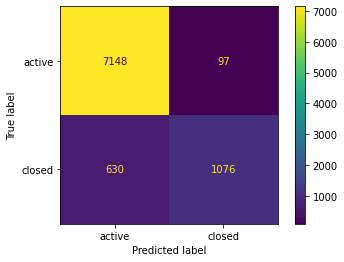

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


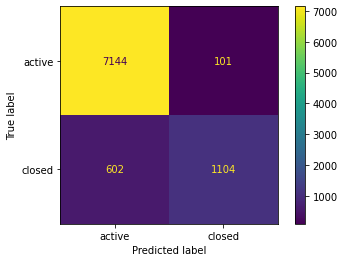

In [ ]:
#모델에 대한 성능평가를 위한 혼동행렬완성하기
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(X_test)
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

[[7148   97]
 [ 630 1076]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7245
           1       0.92      0.63      0.75      1706

    accuracy                           0.92      8951
   macro avg       0.92      0.81      0.85      8951
weighted avg       0.92      0.92      0.91      8951

0.8086632896358164
[[7144  101]
 [ 602 1104]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7245
           1       0.92      0.65      0.76      1706

    accuracy                           0.92      8951
   macro avg       0.92      0.82      0.86      8951
weighted avg       0.92      0.92      0.92      8951

0.8165935677837406


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_te

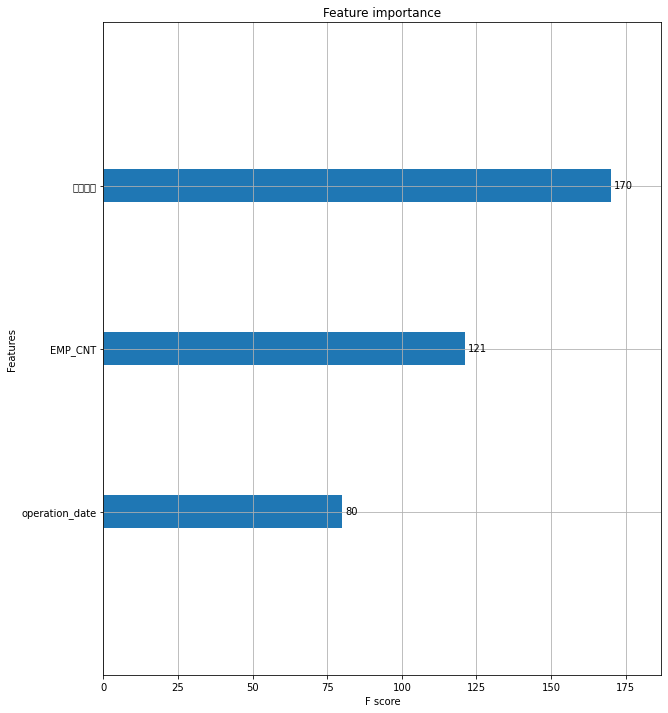

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_te

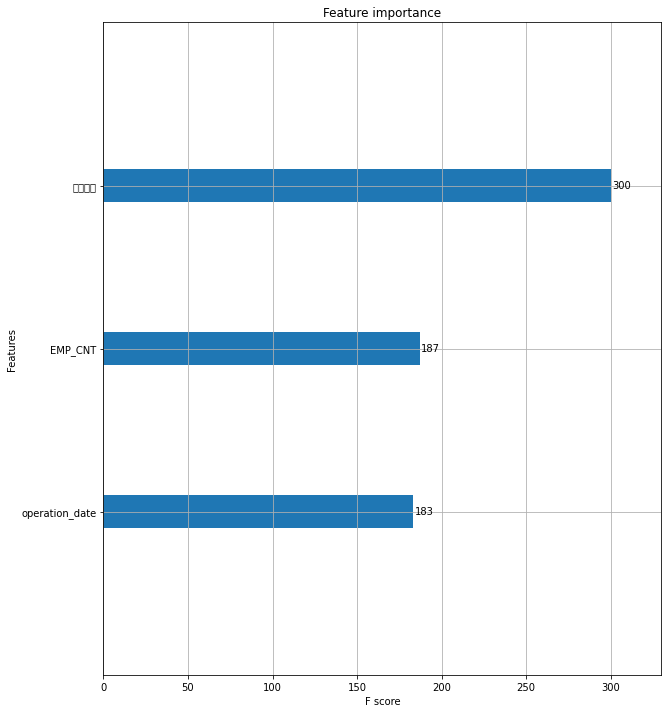

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

XGboost 에서 Fscore는 tree를 분할할때 특정 feature가 얼마나 자주 사용되었는지 보여주는 지표이다. 100% 백분율로 중요도를 보고 싶으면 특정 feature Fscore / 전체 Fscore 총합을 계산하면 된다.
EMP_CNT와 Operation_date의 Fscore 백분위는 각각 0.28, 0.26이다.
5년이상인 long column은 아예 사용되지 않은듯 하다.


# 모델 1

In [ ]:
# 창업어려움정도_입지선정과 기준고용률 이행현황황을 기준으로 XGboost 모델 구축해보기
# csv 파일 불러오기
dif_loc = pd.read_csv('/content/drive/MyDrive/휴페업데이터/창업어려움정도_입지선정.csv', encoding = 'euc-kr')
print(dif_loc)

emp_down = pd.read_csv('/content/drive/MyDrive/휴페업데이터/기준고용률_이행현황.csv', encoding = 'euc-kr')

        시도별                     산업별     2018     2018.1  2018.2    2018.3  \
0       NaN                     NaN       합계  0%(어려움없음)     25%  50%(어려움)   
1        전국                     전산업  1036092     161961  175734    302020   
2        전국                     제조업   103655      20987   24913     33506   
3        전국                     건설업    43179      10847   10930     13034   
4        전국                도매 및 소매업   300403      48747   49256     86841   
5        전국               숙박 및 음식점업   294312      40149   42569     83838   
6        전국                   정보통신업    10737       3461    2480      3067   
7        전국                    부동산업    47269       5900    7953     13563   
8        전국              전문과학기술서비스업    18021       4576    4620      4811   
9        전국  사업시설관리, 사업지원 및 임대 서비스업    19970       3909    4763      6193   
10       전국                 교육 서비스업    61560       8949    8752     15540   
11       전국     예술, 스포츠 및 여가관련 서비스업    39853       3874    4283     11765   

In [ ]:
# 필요한 행과 열 추출
dif_loc = dif_loc.loc[[2,3,4,6,8],:]
dif_loc = dif_loc.drop(['시도별'],axis = 1)

In [ ]:
# 데이터의 타입 변경
dif_loc.set_index('산업별',inplace=True)
dif_loc = dif_loc.astype('float')
dif_loc.reset_index(inplace=True)

In [ ]:
# 산업코드 열 추가
dif_loc['산업코드_eng'] = ['C', 'F', 'G', 'J', 'M']

In [ ]:
# 3개년 평균 
dif_loc['sum'] = round((dif_loc['2018'] + dif_loc['2019'] + dif_loc['2020']) / 3, 2)
dif_loc['0%'] = round((dif_loc['2018.1'] + dif_loc['2019.1'] + dif_loc['2020.1']) / 3, 2)
dif_loc['25%'] = round((dif_loc['2018.2'] + dif_loc['2019.2'] + dif_loc['2020.2']) / 3, 2)
dif_loc['50%'] = round((dif_loc['2018.3'] + dif_loc['2019.3'] + dif_loc['2020.3']) / 3, 2)
dif_loc['75%'] = round((dif_loc['2018.4'] + dif_loc['2019.4'] + dif_loc['2020.4']) / 3, 2)
dif_loc['100%'] = round((dif_loc['2018.5'] + dif_loc['2019.5'] + dif_loc['2020.5']) / 3, 2)

In [ ]:
# 기업 수에 어려움 정도 비율을 곱한뒤 sum으로 나눠준 열 생성
dif_loc['dif_loc_rate'] = round((dif_loc['0%'] * 0 + dif_loc['25%'] * 0.25 + dif_loc['50%'] * 0.50 + dif_loc['75%'] * 0.75 + dif_loc['100%'] * 1.00) / dif_loc['sum'], 2)

In [ ]:
# 사용할 열 추출
dif_loc = dif_loc.loc[:, ['산업코드_eng', 'dif_loc_rate']]
print(dif_loc)

  산업코드_eng  dif_loc_rate
0        C          0.43
1        F          0.41
2        G          0.51
3        J          0.39
4        M          0.41
  산업코드_eng  dif_loc_rate
0        C          0.43
1        F          0.41
2        G          0.51
3        J          0.39
4        M          0.41


In [ ]:
# 필요한 행과 열 추출
emp_down = emp_down.loc[[4,7,8,14],['구분별','2018.4', '2019.4', '2020.4']]

In [ ]:
# 데이터의 타입 변경
emp_down.set_index('구분별',inplace=True)
emp_down = emp_down.astype('float')
emp_down.reset_index(inplace=True)

In [ ]:
# 3개년 평균 열 추가
emp_down['emp_down'] = round((emp_down['2018.4'] + emp_down['2019.4'] + emp_down['2020.4'])/3,2)

In [ ]:
# 산업코드 열 추가
emp_down['산업코드_eng'] = ['C', 'F', 'G', 'M']

In [ ]:
# 필요없는 열 삭제
emp_down = emp_down.loc[:,['emp_down', '산업코드_eng']]
print(emp_down)

   emp_down 산업코드_eng
0     20.21        C
1      5.56        F
2     66.57        G
3     21.03        M
   emp_down 산업코드_eng
0     20.21        C
1      5.56        F
2     66.57        G
3     21.03        M


In [ ]:
finance = pd.read_csv('/content/drive/MyDrive/휴페업데이터/재무데이터+산업코드_최종.csv', encoding = 'UTF-8')

# 산업코드_eng 열을 기준으로 코드 병합
df = pd.merge(finance, emp_down)
df_1 = pd.merge(df, dif_loc)

In [ ]:
# 필요한 행과 열만 추출
ind_code_list = ['C', 'F', 'G', 'M']
finance = finance[finance['산업코드_eng'].isin(ind_code_list)]
print(df_1)
df_1['산업코드_eng'].value_counts()
df_1.to_csv('df_1.csv')

            사업자번호         유동자산        매출채권        비유동자산        유형자산  \
0      1018104991   5466021.50  1633664.00   4158833.00  1126269.25   
1      1018135422   2722000.00  1088000.00   1843000.00  1245000.00   
2      1018151742  38283337.50  1837755.75   7289363.75    92051.00   
3      1018164820  16916278.50  1351129.00   1569708.50   286668.50   
4      1018173159  19535749.50   766691.50   1324708.00   154110.00   
...           ...          ...         ...          ...         ...   
23869  8978101305  30019654.50         NaN    200000.00         NaN   
23870  8978801037  42486094.75         NaN  26143750.50         NaN   
23871  8978801662   2561005.00    15745.00  40338469.00     9529.00   
23872  8978801925  15705260.50   596657.00     62500.00         NaN   
23873  8998700283   1008218.00   494015.00    295045.00    27505.00   

              자산총계         유동부채        비유동부채         부채총계         자본금  ...  \
0       9624854.50   3607055.00   4205618.50   7812673.50    866710.0

In [ ]:
# 독립변수, 종속변수 설정 및 XGboost 모델 구축
X = df_1.iloc[:,[5,-2,-1]]
print(X)
Y = df_1['폐업여부']

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y)
print(sum(Y)/len(Y))
print(sum(y_train)/len(y_train))

clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
clf_xgb.fit(X_train,
           y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)])

              자산총계  emp_down  dif_loc_rate
0       9624854.50     21.03          0.41
1       4565000.00     21.03          0.41
2      45572701.25     21.03          0.41
3      18485986.75     21.03          0.41
4      20860457.50     21.03          0.41
...            ...       ...           ...
23869  30119654.50      5.56          0.41
23870  68629845.25      5.56          0.41
23871  42899475.00      5.56          0.41
23872  15767760.50      5.56          0.41
23873   1303263.00      5.56          0.41

[23874 rows x 3 columns]
0.20373628214794337
0.20374197151633622
[0]	validation_0-aucpr:0.800341
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.808048
[2]	validation_0-aucpr:0.807419
[3]	validation_0-aucpr:0.806801
[4]	validation_0-aucpr:0.812454
[5]	validation_0-aucpr:0.812607
[6]	validation_0-aucpr:0.816087
[7]	validation_0-aucpr:0.816035
[8]	validation_0-aucpr:0.816005
[9]	validation_0-aucpr:0.816734
[10]	validation_0-aucpr:0.816642

XGBClassifier()

              자산총계  emp_down  dif_loc_rate
0       9624854.50     21.03          0.41
1       4565000.00     21.03          0.41
2      45572701.25     21.03          0.41
3      18485986.75     21.03          0.41
4      20860457.50     21.03          0.41
...            ...       ...           ...
23869  30119654.50      5.56          0.41
23870  68629845.25      5.56          0.41
23871  42899475.00      5.56          0.41
23872  15767760.50      5.56          0.41
23873   1303263.00      5.56          0.41

[23874 rows x 3 columns]
0.20373628214794337
0.20374197151633622
[0]	validation_0-aucpr:0.803106
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.807781
[2]	validation_0-aucpr:0.816962
[3]	validation_0-aucpr:0.817425
[4]	validation_0-aucpr:0.817392
[5]	validation_0-aucpr:0.817732
[6]	validation_0-aucpr:0.817855
[7]	validation_0-aucpr:0.817811
[8]	validation_0-aucpr:0.817858
[9]	validation_0-aucpr:0.817909
[10]	validation_0-aucpr:0.817913

XGBClassifier()

AUC 값이 0.82로 나옴.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


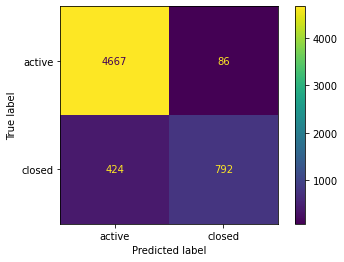

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


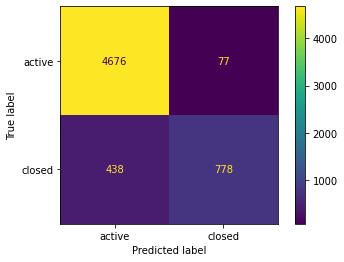

In [ ]:
#모델에 대한 성능평가를 위한 혼동행렬완성하기
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(X_test)

In [ ]:
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

[[4667   86]
 [ 424  792]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      4753
         1.0       0.90      0.65      0.76      1216

    accuracy                           0.91      5969
   macro avg       0.91      0.82      0.85      5969
weighted avg       0.91      0.91      0.91      5969

0.8166109770006754
[[4676   77]
 [ 438  778]]
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      4753
         1.0       0.91      0.64      0.75      1216

    accuracy                           0.91      5969
   macro avg       0.91      0.81      0.85      5969
weighted avg       0.91      0.91      0.91      5969

0.8118011685140686


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_te

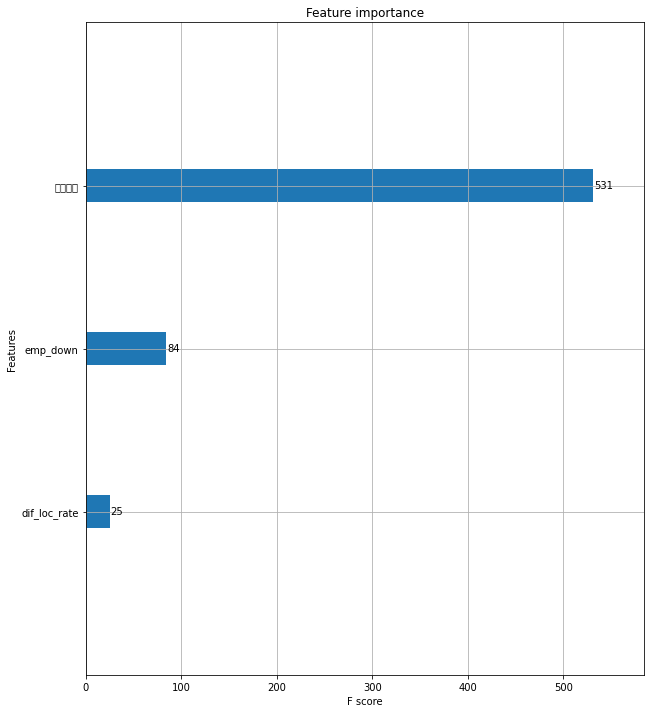

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_te

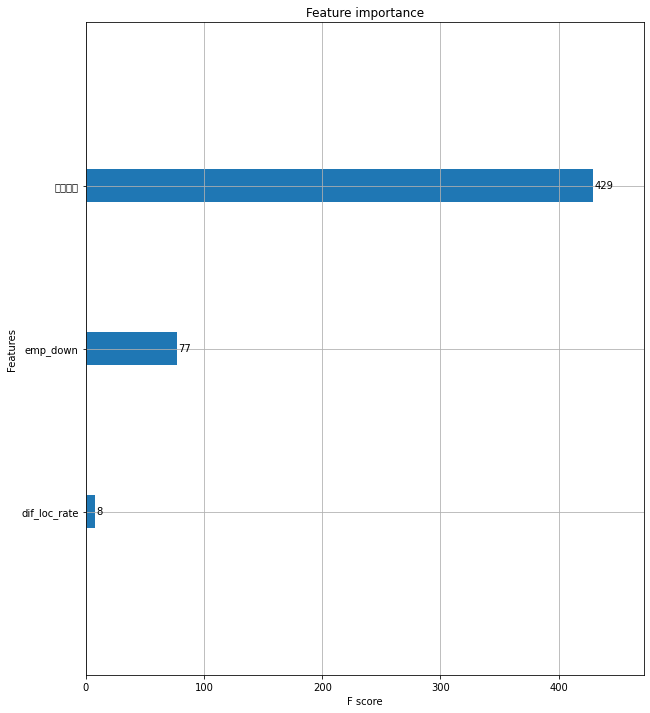

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

Feature Importance에서 비재무적 기준에 해당하는 기준고용률 미달비율, 창업의 어려움정도가 전체의 17%밖에 차지하지 못해 처음에 목표했던 비 재무적 폐업 예측 모델과는 거리가 있음.

In [ ]:
#### AUC가 너무 낮아서 사용하지 못했던 모델들####

# X = df_2.iloc[:,[5,-2,-1]]
# print(X)
# Y = df_2['폐업여부']

# X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y)
# print(sum(Y)/len(Y))
# print(sum(y_train)/len(y_train))

# clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
# clf_xgb.fit(X_train,
#            y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric = 'aucpr',
#             eval_set = [(X_test, y_test)])

# XGboost 구동시 dif_ad feature값은 나오지 않음 --> 영향 전혀 X



# X_1 = df_2.iloc[:,[18,-2,-1]]
# print(X_1)
# Y = df_2['폐업여부']


# X_train, X_test, y_train, y_test = train_test_split(X_1, Y, stratify=Y)
# print(sum(Y)/len(Y))
# print(sum(y_train)/len(y_train))

# clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
# clf_xgb.fit(X_train,
#            y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric = 'aucpr',
#             eval_set = [(X_test, y_test)])

# AUC 0.4 



# X_2 = df_2.iloc[:,[13,-2,-1]]
# print(X_2)
# Y = df_2['폐업여부']

# X_train, X_test, y_train, y_test = train_test_split(X_2, Y, stratify=Y)
# print(sum(Y)/len(Y))
# print(sum(y_train)/len(y_train))

# clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
# clf_xgb.fit(X_train,
#            y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric = 'aucpr',
#             eval_set = [(X_test, y_test)])

# AUC 0.7 내외
# 비재무 feature importance 10 %



# X_3 = df_2.iloc[:,[12,-2,-1]]
# print(X_3)
# Y = df_2['폐업여부']

# X_train, X_test, y_train, y_test = train_test_split(X_3, Y, stratify=Y)
# print(sum(Y)/len(Y))
# print(sum(y_train)/len(y_train))

# clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
# clf_xgb.fit(X_train,
#            y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric = 'aucpr',
#             eval_set = [(X_test, y_test)])

# AUC 0.6중후반



# X_4 = df_2.iloc[:,[16,-2,-1]]
# print(X_4)
# Y = df_1['폐업여부']

# X_train, X_test, y_train, y_test = train_test_split(X_4, Y, stratify=Y)
# print(sum(Y)/len(Y))
# print(sum(y_train)/len(y_train))

# clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
# clf_xgb.fit(X_train,
#            y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric = 'aucpr',
#             eval_set = [(X_test, y_test)])

# AUC 0.52

# X_new = df_1.iloc[:,[5,12,13,-2,-1]]
# print(X_new)
# Y = df_1['폐업여부']

# X_train, X_test, y_train, y_test = train_test_split(X_new, Y, stratify=Y)
# print(sum(Y)/len(Y))
# print(sum(y_train)/len(y_train))

# clf_xgb = xgb.XGBClassifier(objective='binary:logistic',missing=None)
# clf_xgb.fit(X_train,
#            y_train,
#             verbose=True,
#             early_stopping_rounds=10,
#             eval_metric = 'aucpr',
#             eval_set = [(X_test, y_test)])

# AUC 0.86
# 비재무 feature importance 5 %

**다음 단계: 모든 재무적 데이터와 비재무적 데이터 합치기**

In [ ]:
# 재무적 데이터와 코스닥 현황, 산재보험 요양보상 통계를를 취합해 놓은 데이터 불러오기
dff_merge = pd.read_csv('/content/drive/MyDrive/휴페업데이터/결합코드.csv')
print(dff_merge)

       Unnamed: 0         유동자산         매출채권         비유동자산         유형자산  \
0               0   2070964.50    143384.75  3.549089e+07   1118160.75   
1               1   1491190.25    102136.25  3.550742e+07  34353222.50   
2               2    542813.50    144011.75  2.465907e+07  22009393.00   
3               3   1667547.00     48041.25  1.150967e+07  11086486.50   
4               4    576237.75     78056.25  4.985173e+07   9527462.25   
...           ...          ...          ...           ...          ...   
35543       35543  86395970.00  19887419.00  3.149718e+07   5990573.00   
35544       35544   4764438.75   1961091.75  1.451981e+06     81196.00   
35545       35545   3263704.50     86510.00  1.007745e+08  99042472.00   
35546       35546  11599713.33   3610706.50  1.192185e+06    191599.00   
35547       35547    804112.25     26520.00  9.410599e+06   9407599.25   

               자산총계          유동부채        비유동부채          부채총계           자본금  \
0      3.756186e+07  5.333542e+06

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/휴페업데이터/재무데이터+산업코드_최종.csv') 

# 나이스 비즈인포 데이터 추가로 결합
df2 = pd.read_csv('/content/drive/MyDrive/휴페업데이터/나이스 비즈인포 데이터.csv', encoding = 'cp949')
df2_new = df2.copy()

df2_new = df2_new.drop(['address','industry','employee','ind_rank'], axis = 1)


In [ ]:
df2_new['payroll'] = df2_new['payroll'].fillna(df2_new['payroll'].mode()[0])
df2_new['new_payroll'] = df2_new['new_payroll'].fillna(df2_new['new_payroll'].mode()[0])
df2_new['employment'] = df2_new['employment'].fillna(df2_new['employment'].median())
df2_new['resignation'] = df2_new['resignation'].fillna(df2_new['resignation'].median())
df2_new['cmp_years'] = df2_new['cmp_years'].fillna(df2_new['cmp_years'].median())
df2_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35709 entries, 0 to 35708
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   사업자번호        35709 non-null  int64  
 1   payroll      35709 non-null  float64
 2   new_payroll  35709 non-null  float64
 3   employment   35709 non-null  float64
 4   resignation  35709 non-null  float64
 5   cmp_years    35709 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35709 entries, 0 to 35708
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   사업자번호        35709 non-null  int64  
 1   payroll      35709 non-null  float64
 2   new_payroll  35709 non-null  float64
 3   employment   35709 non-null  float64
 4   resignation  35709 non-null  float64
 5   cmp_years    35709 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.6 MB


In [ ]:
dff = df.copy()

In [ ]:
dff.isnull().sum()

사업자번호               0
유동자산                9
매출채권             1402
비유동자산             121
유형자산              734
자산총계                8
유동부채               29
비유동부채            1961
부채총계               18
자본금                15
이익잉여금(결손금)        110
자본총계               10
매출액               378
판매비와관리비           116
영업이익(손실)           24
법인세비용차감전순손익       108
법인세비용            4498
당기순이익(손실)          17
기업순이익률              0
유보액/총자산(%)          1
유보액/납입자본(%)         1
매출액총이익률(%)          9
매출액영업이익률(%)         9
매출액순이익률(%)          9
수지비율(%)             4
경상수지비율(%)           5
영업비율(%)             9
금융비용대매출액비율(%)      38
금융비용대부채비율(%)        0
금융비용대총비용비율(%)      36
부채비율(%)             0
차입금의존도(%)           1
자기자본비율(%)           0
순운전자본비율(%)          0
유동부채비율(%)           0
비유동부채비율(%)         19
부채총계대매출액(%)         9
총자본회전율(회)           0
재고자산회전율(회)          0
매출채권회전율(회)         16
매입채무회전율(회)         21
미수금              3650
매출원가             1262
무형자산             9581
재고자산             3031
산업코드      

사업자번호               0
유동자산                9
매출채권             1402
비유동자산             121
유형자산              734
자산총계                8
유동부채               29
비유동부채            1961
부채총계               18
자본금                15
이익잉여금(결손금)        110
자본총계               10
매출액               378
판매비와관리비           116
영업이익(손실)           24
법인세비용차감전순손익       108
법인세비용            4498
당기순이익(손실)          17
기업순이익률              0
유보액/총자산(%)          1
유보액/납입자본(%)         1
매출액총이익률(%)          9
매출액영업이익률(%)         9
매출액순이익률(%)          9
수지비율(%)             4
경상수지비율(%)           5
영업비율(%)             9
금융비용대매출액비율(%)      38
금융비용대부채비율(%)        0
금융비용대총비용비율(%)      36
부채비율(%)             0
차입금의존도(%)           1
자기자본비율(%)           0
순운전자본비율(%)          0
유동부채비율(%)           0
비유동부채비율(%)         19
부채총계대매출액(%)         9
총자본회전율(회)           0
재고자산회전율(회)          0
매출채권회전율(회)         16
매입채무회전율(회)         21
미수금              3650
매출원가             1262
무형자산             9581
재고자산             3031
산업코드      

In [ ]:
dff.drop(dff[dff['폐업여부'].isnull()].index,axis=0, inplace=True)
dff['산업코드_eng'].value_counts()

C    13503
G     5941
F     3095
M     1335
Name: 산업코드_eng, dtype: int64

C    13503
G     5941
F     3095
M     1335
Name: 산업코드_eng, dtype: int64

In [ ]:
dff_merge['사업자번호'] = dff['사업자번호']
dff_merge.drop('Unnamed: 0',axis=1,inplace=True)
print(dff_merge)


              유동자산         매출채권         비유동자산         유형자산          자산총계  \
0       2070964.50    143384.75  3.549089e+07   1118160.75  3.756186e+07   
1       1491190.25    102136.25  3.550742e+07  34353222.50  3.699861e+07   
2        542813.50    144011.75  2.465907e+07  22009393.00  2.520188e+07   
3       1667547.00     48041.25  1.150967e+07  11086486.50  1.317722e+07   
4        576237.75     78056.25  4.985173e+07   9527462.25  5.042796e+07   
...            ...          ...           ...          ...           ...   
35543  86395970.00  19887419.00  3.149718e+07   5990573.00  1.178932e+08   
35544   4764438.75   1961091.75  1.451981e+06     81196.00  6.216420e+06   
35545   3263704.50     86510.00  1.007745e+08  99042472.00  1.040382e+08   
35546  11599713.33   3610706.50  1.192185e+06    191599.00  1.279190e+07   
35547    804112.25     26520.00  9.410599e+06   9407599.25  1.021471e+07   

               유동부채        비유동부채          부채총계           자본금   이익잉여금(결손금)  \
0      5.3

In [ ]:
dff_merge['산업코드_eng'].value_counts()

C    13503
G     5941
L     4515
F     3095
J     1419
M     1335
H     1186
N     1157
K      780
I      774
R      492
E      331
S      304
P      217
A      185
D      172
B       96
Q       40
O        6
Name: 산업코드_eng, dtype: int64

C    13503
G     5941
L     4515
F     3095
J     1419
M     1335
H     1186
N     1157
K      780
I      774
R      492
E      331
S      304
P      217
A      185
D      172
B       96
Q       40
O        6
Name: 산업코드_eng, dtype: int64

In [ ]:
# 5개년 
data = pd.read_csv('/content/drive/MyDrive/휴페업데이터/finance_5years.csv', encoding = 'euc-kr')
print(data)

       Unnamed: 0      BIZ_NO          자산총계  operation_date  EMP_CNT  long  \
0               1  1018100340  3.756186e+07         24049.0     41.0   1.0   
1               2  1018100772  2.137594e+07         19341.0      3.0   1.0   
2               3  1018101126  3.699861e+07         20040.0     13.0   1.0   
3               4  1018101242  2.520188e+07         18942.0     17.0   1.0   
4               5  1018103819  1.317722e+07         18946.0      4.0   1.0   
...           ...         ...           ...             ...      ...   ...   
35797       35798  8998700283  1.303263e+06          2147.0      5.0   1.0   
35798       35799  8998701263  9.025398e+06          1172.0      2.0   0.0   
35799       35800  8998800150  3.186404e+07          3962.0    106.0   1.0   
35800       35801  8998800427  1.442572e+07          2283.0     59.0   1.0   
35801       35802  8998800785  3.445220e+08          1841.0      0.0   1.0   

       new_col  
0            0  
1            0  
2           

In [ ]:
data = data.rename(columns={'BIZ_NO':'사업자번호','operation_date':'기업기간','EMP_CNT':'근로자수'})
data.drop(['Unnamed: 0', '자산총계', 'new_col','long'],axis=1,inplace=True)

In [ ]:
df_merge = pd.merge(dff_merge, data, on='사업자번호')
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23936 entries, 0 to 23935
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             23936 non-null  float64
 1   매출채권             23936 non-null  float64
 2   비유동자산            23936 non-null  float64
 3   유형자산             23936 non-null  float64
 4   자산총계             23936 non-null  float64
 5   유동부채             23936 non-null  float64
 6   비유동부채            23936 non-null  float64
 7   부채총계             23936 non-null  float64
 8   자본금              23936 non-null  float64
 9   이익잉여금(결손금)       23936 non-null  float64
 10  자본총계             23936 non-null  float64
 11  매출액              23936 non-null  float64
 12  판매비와관리비          23936 non-null  float64
 13  영업이익(손실)         23936 non-null  float64
 14  법인세비용차감전순손익      23936 non-null  float64
 15  법인세비용            23936 non-null  float64
 16  당기순이익(손실)        23936 non-null  float64
 17  기업순이익률      

In [ ]:
df_merge['산업코드_eng'].value_counts()

C    10847
G     5948
L     4531
M     1340
I      775
R      495
Name: 산업코드_eng, dtype: int64

C    10847
G     5948
L     4531
M     1340
I      775
R      495
Name: 산업코드_eng, dtype: int64

In [ ]:
# 산업코드별로 많은 기업을 업종별로 몇 가지만 선정
dt = dff_merge[(dff_merge['산업코드_eng'] == 'C') | (dff_merge['산업코드_eng'] == 'G')|(dff_merge['산업코드_eng'] == 'F')|(dff_merge['산업코드_eng'] == 'J')|(dff_merge['산업코드_eng'] == 'M')]

dt['산업코드_eng'].value_counts()

C    13503
G     5941
F     3095
J     1419
M     1335
Name: 산업코드_eng, dtype: int64

C    13503
G     5941
F     3095
J     1419
M     1335
Name: 산업코드_eng, dtype: int64

In [ ]:
# Gas와 Energy 데이터 불러오기
dt_gE = pd.read_csv('/content/drive/MyDrive/휴페업데이터/Gas.csv')
print(dt_gE)
dt_gE.info()


    IND_CD1  number       Gas   Energy
0         P      13  727,275   14,897 
1         H       3  514,328   10,180 
2         Q       5  331,272    6,731 
3         K       1   66,825      911 
4         L       4  171,192    3,497 
..      ...     ...       ...      ...
98        H       1   51,432      705 
99        E       8  554,517    5,229 
100       E       6  349,615    2,117 
101       E       4  163,541    1,410 
102       E       2   40,231      415 

[103 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   IND_CD1  103 non-null    object
 1   number   103 non-null    int64 
 2   Gas      103 non-null    object
 3   Energy   103 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
    IND_CD1  number       Gas   Energy
0         P      13  727,275   14,897 
1         H       3  514,328   10,180 
2         Q    

In [ ]:
dt_gE['Gas'] = dt_gE['Gas'].str.replace(',','')
dt_gE['Energy'] = dt_gE['Energy'].str.replace(',','')


In [ ]:
# 데이터 타입 변경
dt_gE.set_index('IND_CD1',inplace=True)
dt_gE = dt_gE.astype('int64')   #inplace 가 없음
dt_gE.reset_index(inplace=True)
print(dt_gE)

    IND_CD1  number     Gas  Energy
0         P      13  727275   14897
1         H       3  514328   10180
2         Q       5  331272    6731
3         K       1   66825     911
4         L       4  171192    3497
..      ...     ...     ...     ...
98        H       1   51432     705
99        E       8  554517    5229
100       E       6  349615    2117
101       E       4  163541    1410
102       E       2   40231     415

[103 rows x 4 columns]
    IND_CD1  number     Gas  Energy
0         P      13  727275   14897
1         H       3  514328   10180
2         Q       5  331272    6731
3         K       1   66825     911
4         L       4  171192    3497
..      ...     ...     ...     ...
98        H       1   51432     705
99        E       8  554517    5229
100       E       6  349615    2117
101       E       4  163541    1410
102       E       2   40231     415

[103 rows x 4 columns]


In [ ]:
# IND_CD1 별로 groupby 해준다.
dt_gas = dt_gE.groupby('IND_CD1').sum()
dt_gas['Gas_avg'] = dt_gas['Gas'] / dt_gas['number']
dt_gas['Energy_avg'] = dt_gas['Energy'] / dt_gas['number']
print(dt_gas)

         number        Gas   Energy       Gas_avg    Energy_avg
IND_CD1                                                        
A             4     181060     3883  4.526500e+04    970.750000
C           689  318293866  3735058  4.619650e+05   5420.984035
D            60  236002256  3183207  3.933371e+06  53053.450000
E            92   14909183    98967  1.620563e+05   1075.728261
F            61    1847657    34543  3.028946e+04    566.278689
G             6    2049938    41302  3.416563e+05   6883.666667
H           107    7602647   131510  7.105278e+04   1229.065421
I             4     228786     4594  5.719650e+04   1148.500000
J            10    4149918    85198  4.149918e+05   8519.800000
K             1      66825      911  6.682500e+04    911.000000
L             4     171192     3497  4.279800e+04    874.250000
O             4     987771    20236  2.469428e+05   5059.000000
P            13     727275    14897  5.594423e+04   1145.923077
Q             5     331272     6731  6.6

In [ ]:
dt_gas = dt_gas.reset_index()
print(dt_gas)

   IND_CD1  number        Gas   Energy       Gas_avg    Energy_avg
0        A       4     181060     3883  4.526500e+04    970.750000
1        C     689  318293866  3735058  4.619650e+05   5420.984035
2        D      60  236002256  3183207  3.933371e+06  53053.450000
3        E      92   14909183    98967  1.620563e+05   1075.728261
4        F      61    1847657    34543  3.028946e+04    566.278689
5        G       6    2049938    41302  3.416563e+05   6883.666667
6        H     107    7602647   131510  7.105278e+04   1229.065421
7        I       4     228786     4594  5.719650e+04   1148.500000
8        J      10    4149918    85198  4.149918e+05   8519.800000
9        K       1      66825      911  6.682500e+04    911.000000
10       L       4     171192     3497  4.279800e+04    874.250000
11       O       4     987771    20236  2.469428e+05   5059.000000
12       P      13     727275    14897  5.594423e+04   1145.923077
13       Q       5     331272     6731  6.625440e+04   1346.20

In [ ]:
# 열 이름 변경 및 사용하지 않는 열 삭제 후 데이터 병함함
dt_gas = dt_gas.rename(columns={'IND_CD1':'산업코드_eng'})
dtt_gas = dt_gas.drop(['number', 'Gas', 'Energy'], axis=1)
dtt_gas

,산업코드_eng,Gas_avg,Energy_avg
0,A,4.526500e+04,970.750000
1,C,4.619650e+05,5420.984035
2,D,3.933371e+06,53053.450000
3,E,1.620563e+05,1075.728261
4,F,3.028946e+04,566.278689
5,G,3.416563e+05,6883.666667
6,H,7.105278e+04,1229.065421
7,I,5.719650e+04,1148.500000
8,J,4.149918e+05,8519.800000
9,K,6.682500e+04,911.000000


,산업코드_eng,Gas_avg,Energy_avg
0,A,4.526500e+04,970.750000
1,C,4.619650e+05,5420.984035
2,D,3.933371e+06,53053.450000
3,E,1.620563e+05,1075.728261
4,F,3.028946e+04,566.278689
5,G,3.416563e+05,6883.666667
6,H,7.105278e+04,1229.065421
7,I,5.719650e+04,1148.500000
8,J,4.149918e+05,8519.800000
9,K,6.682500e+04,911.000000


In [ ]:
dt_merge_gas = pd.merge(dt, dtt_gas, on='산업코드_eng')
dt_merge_gas['산업코드_eng'].value_counts()

C    13503
G     5941
F     3095
J     1419
Name: 산업코드_eng, dtype: int64

C    13503
G     5941
F     3095
J     1419
Name: 산업코드_eng, dtype: int64

In [ ]:
dt_new = pd.merge(dt_merge_gas, df2_new, on='사업자번호')
dt_new.info()
dt_new['산업코드_eng'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16758 entries, 0 to 16757
Data columns (total 68 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             16758 non-null  float64
 1   매출채권             16758 non-null  float64
 2   비유동자산            16758 non-null  float64
 3   유형자산             16758 non-null  float64
 4   자산총계             16758 non-null  float64
 5   유동부채             16758 non-null  float64
 6   비유동부채            16758 non-null  float64
 7   부채총계             16758 non-null  float64
 8   자본금              16758 non-null  float64
 9   이익잉여금(결손금)       16758 non-null  float64
 10  자본총계             16758 non-null  float64
 11  매출액              16758 non-null  float64
 12  판매비와관리비          16758 non-null  float64
 13  영업이익(손실)         16758 non-null  float64
 14  법인세비용차감전순손익      16758 non-null  float64
 15  법인세비용            16758 non-null  float64
 16  당기순이익(손실)        16758 non-null  float64
 17  기업순이익률      

C    10817
G     5941
Name: 산업코드_eng, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16758 entries, 0 to 16757
Data columns (total 68 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             16758 non-null  float64
 1   매출채권             16758 non-null  float64
 2   비유동자산            16758 non-null  float64
 3   유형자산             16758 non-null  float64
 4   자산총계             16758 non-null  float64
 5   유동부채             16758 non-null  float64
 6   비유동부채            16758 non-null  float64
 7   부채총계             16758 non-null  float64
 8   자본금              16758 non-null  float64
 9   이익잉여금(결손금)       16758 non-null  float64
 10  자본총계             16758 non-null  float64
 11  매출액              16758 non-null  float64
 12  판매비와관리비          16758 non-null  float64
 13  영업이익(손실)         16758 non-null  float64
 14  법인세비용차감전순손익      16758 non-null  float64
 15  법인세비용            16758 non-null  float64
 16  당기순이익(손실)        16758 non-null  float64
 17  기업순이익률      

C    10817
G     5941
Name: 산업코드_eng, dtype: int64

In [ ]:
dt_merge_gas['산업코드_eng'].value_counts()

C    13503
G     5941
F     3095
J     1419
Name: 산업코드_eng, dtype: int64

C    13503
G     5941
F     3095
J     1419
Name: 산업코드_eng, dtype: int64

In [ ]:
new = pd.read_csv('/content/drive/MyDrive/휴페업데이터/df_new.csv',encoding='cp949') 
new

,Unnamed: 0,기준고용률 미달비율,산업코드_eng,창업 어려움 정도,경기전반 실적 SBHI
0,0,20.21,C,0.43,80.71
1,1,5.56,F,0.41,74.21
2,2,66.57,G,0.51,78.05
3,3,21.03,M,0.41,85.12
4,4,NaN,J,0.39,85.82


,Unnamed: 0,기준고용률 미달비율,산업코드_eng,창업 어려움 정도,경기전반 실적 SBHI
0,0,20.21,C,0.43,80.71
1,1,5.56,F,0.41,74.21
2,2,66.57,G,0.51,78.05
3,3,21.03,M,0.41,85.12
4,4,NaN,J,0.39,85.82


In [ ]:
new.drop('Unnamed: 0', axis=1,inplace=True)

In [ ]:
dt_merge_new = pd.merge(dt_new, new, on='산업코드_eng')
dt_merge_new
dt_merge_new2 = pd.merge(dt_merge_gas, new, on='산업코드_eng')
dt_merge_new.to_csv("dt_merge_new.csv")

In [ ]:
dt_merge_new = dt_merge_new.drop(['사업자번호'], axis = 1)

In [ ]:
dt_merge_new2 = dt_merge_new2.drop(['사업자번호'], axis = 1)

In [ ]:
dt_merge_new.info()
dt_merge_new['산업코드_eng'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16758 entries, 0 to 16757
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             16758 non-null  float64
 1   매출채권             16758 non-null  float64
 2   비유동자산            16758 non-null  float64
 3   유형자산             16758 non-null  float64
 4   자산총계             16758 non-null  float64
 5   유동부채             16758 non-null  float64
 6   비유동부채            16758 non-null  float64
 7   부채총계             16758 non-null  float64
 8   자본금              16758 non-null  float64
 9   이익잉여금(결손금)       16758 non-null  float64
 10  자본총계             16758 non-null  float64
 11  매출액              16758 non-null  float64
 12  판매비와관리비          16758 non-null  float64
 13  영업이익(손실)         16758 non-null  float64
 14  법인세비용차감전순손익      16758 non-null  float64
 15  법인세비용            16758 non-null  float64
 16  당기순이익(손실)        16758 non-null  float64
 17  기업순이익률      

C    10817
G     5941
Name: 산업코드_eng, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16758 entries, 0 to 16757
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             16758 non-null  float64
 1   매출채권             16758 non-null  float64
 2   비유동자산            16758 non-null  float64
 3   유형자산             16758 non-null  float64
 4   자산총계             16758 non-null  float64
 5   유동부채             16758 non-null  float64
 6   비유동부채            16758 non-null  float64
 7   부채총계             16758 non-null  float64
 8   자본금              16758 non-null  float64
 9   이익잉여금(결손금)       16758 non-null  float64
 10  자본총계             16758 non-null  float64
 11  매출액              16758 non-null  float64
 12  판매비와관리비          16758 non-null  float64
 13  영업이익(손실)         16758 non-null  float64
 14  법인세비용차감전순손익      16758 non-null  float64
 15  법인세비용            16758 non-null  float64
 16  당기순이익(손실)        16758 non-null  float64
 17  기업순이익률      

C    10817
G     5941
Name: 산업코드_eng, dtype: int64

In [ ]:
dt_merge_new2.info()
dt_merge_new2['산업코드_eng'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23958 entries, 0 to 23957
Data columns (total 65 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             23958 non-null  float64
 1   매출채권             23958 non-null  float64
 2   비유동자산            23958 non-null  float64
 3   유형자산             23958 non-null  float64
 4   자산총계             23958 non-null  float64
 5   유동부채             23958 non-null  float64
 6   비유동부채            23958 non-null  float64
 7   부채총계             23958 non-null  float64
 8   자본금              23958 non-null  float64
 9   이익잉여금(결손금)       23958 non-null  float64
 10  자본총계             23958 non-null  float64
 11  매출액              23958 non-null  float64
 12  판매비와관리비          23958 non-null  float64
 13  영업이익(손실)         23958 non-null  float64
 14  법인세비용차감전순손익      23958 non-null  float64
 15  법인세비용            23958 non-null  float64
 16  당기순이익(손실)        23958 non-null  float64
 17  기업순이익률      

C    13503
G     5941
F     3095
J     1419
Name: 산업코드_eng, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23958 entries, 0 to 23957
Data columns (total 65 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             23958 non-null  float64
 1   매출채권             23958 non-null  float64
 2   비유동자산            23958 non-null  float64
 3   유형자산             23958 non-null  float64
 4   자산총계             23958 non-null  float64
 5   유동부채             23958 non-null  float64
 6   비유동부채            23958 non-null  float64
 7   부채총계             23958 non-null  float64
 8   자본금              23958 non-null  float64
 9   이익잉여금(결손금)       23958 non-null  float64
 10  자본총계             23958 non-null  float64
 11  매출액              23958 non-null  float64
 12  판매비와관리비          23958 non-null  float64
 13  영업이익(손실)         23958 non-null  float64
 14  법인세비용차감전순손익      23958 non-null  float64
 15  법인세비용            23958 non-null  float64
 16  당기순이익(손실)        23958 non-null  float64
 17  기업순이익률      

C    13503
G     5941
F     3095
J     1419
Name: 산업코드_eng, dtype: int64

# 모델 4

In [ ]:
# 임금 포함 전
x = pd.concat([dt_merge_new2.iloc[:,:44],dt_merge_new2.iloc[:,47:]], axis=1)
X = x.to_numpy()
Y = dt_merge_new2['폐업여부'].to_numpy() # 타겟 데이터

x.info()

In [ ]:
# MinMaxScaler() 함수로 정규화
scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)
X_scaled = scaler_fit.transform(X)

len(X_scaled)

train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)
print(sum(Y)/len(Y))
print(sum(y_train)/len(y_train))

#XGboost 모델 구축하기 (max_depth = 20)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',max_depth = 20,missing=None)
clf_xgb.fit(train_input,
            train_target,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(test_input, test_target)])

0.20765506302696385
0.20374197151633622
[0]	validation_0-aucpr:0.907488
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.911612
[2]	validation_0-aucpr:0.91452
[3]	validation_0-aucpr:0.918336
[4]	validation_0-aucpr:0.919879
[5]	validation_0-aucpr:0.920646
[6]	validation_0-aucpr:0.921699
[7]	validation_0-aucpr:0.922033
[8]	validation_0-aucpr:0.922357
[9]	validation_0-aucpr:0.922541
[10]	validation_0-aucpr:0.917944
[11]	validation_0-aucpr:0.918508
[12]	validation_0-aucpr:0.923023
[13]	validation_0-aucpr:0.92707
[14]	validation_0-aucpr:0.927514
[15]	validation_0-aucpr:0.927593
[16]	validation_0-aucpr:0.927747
[17]	validation_0-aucpr:0.928413
[18]	validation_0-aucpr:0.928857
[19]	validation_0-aucpr:0.929171
[20]	validation_0-aucpr:0.929189
[21]	validation_0-aucpr:0.92923
[22]	validation_0-aucpr:0.929859
[23]	validation_0-aucpr:0.930565
[24]	validation_0-aucpr:0.930557
[25]	validation_0-aucpr:0.9308
[26]	validation_0-aucpr:0.930867
[27]	validation_0-

XGBClassifier(max_depth=20)

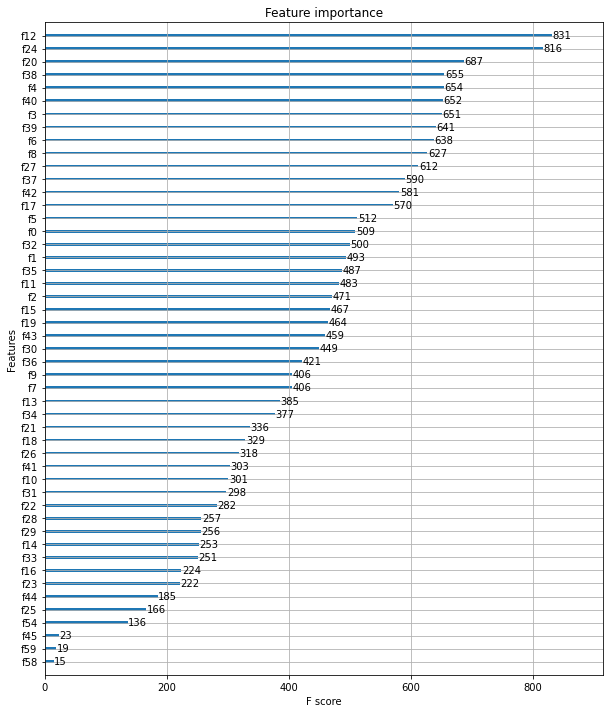

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


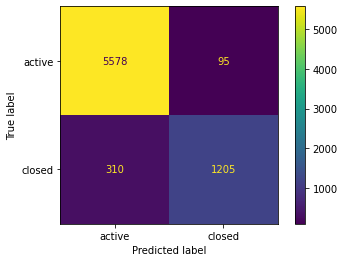

In [ ]:
plot_confusion_matrix(clf_xgb,
                      test_input,
                      test_target,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(test_input)

In [ ]:
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(test_target, y_preds))
print(classification_report(test_target, y_preds))
print(accuracy_score(test_target, y_preds))
print(precision_score(test_target, y_preds))
print(recall_score(test_target, y_preds))
print(f1_score(test_target, y_preds))
print(roc_auc_score(test_target, y_preds))

[[5578   95]
 [ 310 1205]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5673
           1       0.93      0.80      0.86      1515

    accuracy                           0.94      7188
   macro avg       0.94      0.89      0.91      7188
weighted avg       0.94      0.94      0.94      7188

0.9436560934891486
0.926923076923077
0.7953795379537953
0.8561278863232682
0.8893167740888314


In [ ]:
# 임금 포함 후 
final_dt = pd.read_csv('/content/drive/MyDrive/휴페업데이터/최종 결합 데이터(C,G,F,J) - 최종 결합 데이터(C,G,F,J).csv')
final_dt = final_dt.drop(['Unnamed: 0','사업자번호'], axis = 1)
x = pd.concat([final_dt.iloc[:,:44],final_dt.iloc[:,47:]], axis=1)
X = x.to_numpy()
Y = final_dt['폐업여부'].to_numpy() # 타겟 데이터

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24020 entries, 0 to 24019
Data columns (total 68 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             24020 non-null  float64
 1   매출채권             24020 non-null  float64
 2   비유동자산            24020 non-null  float64
 3   유형자산             24020 non-null  float64
 4   자산총계             24020 non-null  float64
 5   유동부채             24020 non-null  float64
 6   비유동부채            24020 non-null  float64
 7   부채총계             24020 non-null  float64
 8   자본금              24020 non-null  float64
 9   이익잉여금(결손금)       24020 non-null  float64
 10  자본총계             24020 non-null  float64
 11  매출액              24020 non-null  float64
 12  판매비와관리비          24020 non-null  float64
 13  영업이익(손실)         24020 non-null  float64
 14  법인세비용차감전순손익      24020 non-null  float64
 15  법인세비용            24020 non-null  float64
 16  당기순이익(손실)        24020 non-null  float64
 17  기업순이익률      

In [ ]:
# MinMaxScaler() 함수로 정규화
scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)
X_scaled = scaler_fit.transform(X)

In [ ]:
len(X_scaled)

24020

In [ ]:
train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)
print(sum(Y)/len(Y))
print(sum(y_train)/len(y_train))

0.20970024979184013
0.20374197151633622


In [ ]:
#XGboost 모델 구축하기 (max_depth = 20)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',max_depth = 20,missing=None)
clf_xgb.fit(train_input,
            train_target,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(test_input, test_target)])

[0]	validation_0-aucpr:0.941209
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.943892
[2]	validation_0-aucpr:0.947752
[3]	validation_0-aucpr:0.948353
[4]	validation_0-aucpr:0.951108
[5]	validation_0-aucpr:0.951737
[6]	validation_0-aucpr:0.952689
[7]	validation_0-aucpr:0.952837
[8]	validation_0-aucpr:0.953008
[9]	validation_0-aucpr:0.953593
[10]	validation_0-aucpr:0.954352
[11]	validation_0-aucpr:0.95529
[12]	validation_0-aucpr:0.955455
[13]	validation_0-aucpr:0.956068
[14]	validation_0-aucpr:0.956738
[15]	validation_0-aucpr:0.95705
[16]	validation_0-aucpr:0.957347
[17]	validation_0-aucpr:0.95738
[18]	validation_0-aucpr:0.957692
[19]	validation_0-aucpr:0.957549
[20]	validation_0-aucpr:0.957702
[21]	validation_0-aucpr:0.958618
[22]	validation_0-aucpr:0.959505
[23]	validation_0-aucpr:0.959626
[24]	validation_0-aucpr:0.959686
[25]	validation_0-aucpr:0.960118
[26]	validation_0-aucpr:0.960648
[27]	validation_0-aucpr:0.960843
[28]	validation_0-aucpr

XGBClassifier(max_depth=20)

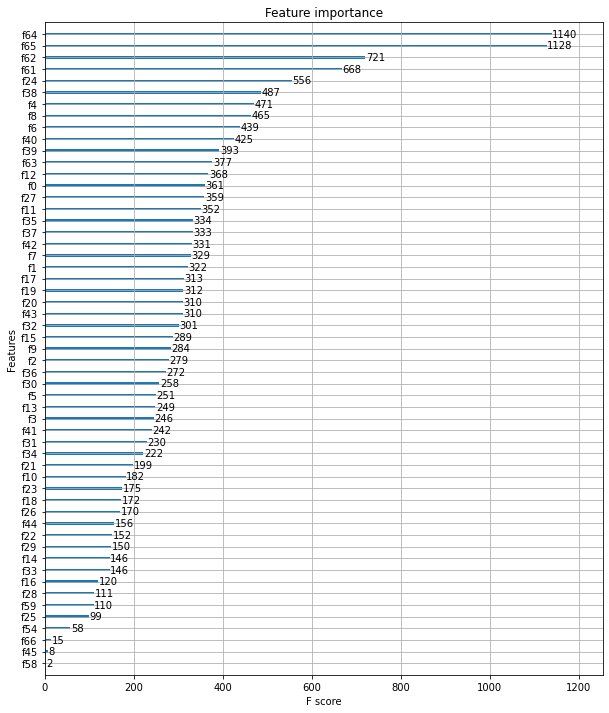

In [ ]:
#feature importance graph
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb, ax=ax)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


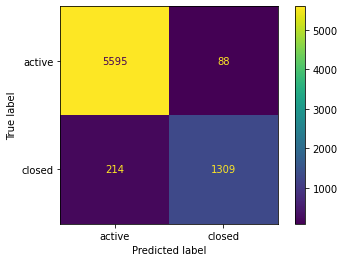

In [ ]:
plot_confusion_matrix(clf_xgb,
                      test_input,
                      test_target,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb.predict(test_input)

In [ ]:
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(test_target, y_preds))
print(classification_report(test_target, y_preds))
print(accuracy_score(test_target, y_preds))
print(precision_score(test_target, y_preds))
print(recall_score(test_target, y_preds))
print(f1_score(test_target, y_preds))
print(roc_auc_score(test_target, y_preds))

[[5580  103]
 [ 223 1300]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5683
           1       0.93      0.85      0.89      1523

    accuracy                           0.95      7206
   macro avg       0.94      0.92      0.93      7206
weighted avg       0.95      0.95      0.95      7206

0.954759922286983
0.9265858873841768
0.8535784635587655
0.8885850991114148
0.9177271166993194


max_depth = 20일때 성능이 더 좋은 것으로 나타남.

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24020 entries, 0 to 24019
Data columns (total 68 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   유동자산             24020 non-null  float64
 1   매출채권             24020 non-null  float64
 2   비유동자산            24020 non-null  float64
 3   유형자산             24020 non-null  float64
 4   자산총계             24020 non-null  float64
 5   유동부채             24020 non-null  float64
 6   비유동부채            24020 non-null  float64
 7   부채총계             24020 non-null  float64
 8   자본금              24020 non-null  float64
 9   이익잉여금(결손금)       24020 non-null  float64
 10  자본총계             24020 non-null  float64
 11  매출액              24020 non-null  float64
 12  판매비와관리비          24020 non-null  float64
 13  영업이익(손실)         24020 non-null  float64
 14  법인세비용차감전순손익      24020 non-null  float64
 15  법인세비용            24020 non-null  float64
 16  당기순이익(손실)        24020 non-null  float64
 17  기업순이익률      

# 모델 5

모델 4를 기준으로 하여 feature importance가 높았던 재무 데이터 몇 개만 추출해서 비재무 데이터와 결합해 모델 구축

In [ ]:
x = pd.concat([final_dt.iloc[:,24],final_dt.iloc[:,4],final_dt.iloc[:,47:]], axis=1)
X = x.to_numpy()
Y = final_dt['폐업여부'].to_numpy() # 타겟 데이터

In [ ]:
print(x)

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24020 entries, 0 to 24019
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   경상수지비율(%)        24020 non-null  float64
 1   자산총계             24020 non-null  float64
 2   고용허가제 외국인근로자 도입  24020 non-null  int64  
 3   산재신청 승인율         24020 non-null  float64
 4   요양급여             24020 non-null  int64  
 5   휴업급여             24020 non-null  int64  
 6   상병보상연금           24020 non-null  int64  
 7   장해급여             24020 non-null  int64  
 8   유족급여             24020 non-null  int64  
 9   장의비              24020 non-null  int64  
 10  간병급여             24020 non-null  int64  
 11  재활급여             24020 non-null  int64  
 12  코스닥_회사수          24020 non-null  int64  
 13  코스닥_상장주식수        24020 non-null  int64  
 14  코스닥_시가총액         24020 non-null  int64  
 15  Gas_avg          24020 non-null  float64
 16  Energy_avg       24020 non-null  float64
 17  payroll     

In [ ]:
print(x.columns)

Index(['경상수지비율(%)', '자산총계', '고용허가제 외국인근로자 도입', '산재신청 승인율', '요양급여', '휴업급여',
       '상병보상연금', '장해급여', '유족급여', '장의비', '간병급여', '재활급여', '코스닥_회사수', '코스닥_상장주식수',
       '코스닥_시가총액', 'Gas_avg', 'Energy_avg', 'payroll', 'new_payroll',
       'employment', 'resignation', 'cmp_years', '기업기간', '근로자수', '기준고용률 미달비율',
       '창업 어려움 정도'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)
X_scaled = scaler_fit.transform(X)

In [ ]:
len(X_scaled)

24020

In [ ]:
train_input, test_input, train_target, test_target = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)

In [ ]:
# XGboost 모델 구축하기
clf_xgb1 = xgb.XGBClassifier(objective='binary:logistic', max_depth = 20, missing=None)
clf_xgb1.fit(train_input,
            train_target,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric = 'aucpr',
            eval_set = [(test_input, test_target)])

[0]	validation_0-aucpr:0.931254
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.93444
[2]	validation_0-aucpr:0.940753
[3]	validation_0-aucpr:0.944601
[4]	validation_0-aucpr:0.945652
[5]	validation_0-aucpr:0.945949
[6]	validation_0-aucpr:0.946707
[7]	validation_0-aucpr:0.94726
[8]	validation_0-aucpr:0.948297
[9]	validation_0-aucpr:0.948688
[10]	validation_0-aucpr:0.949357
[11]	validation_0-aucpr:0.951581
[12]	validation_0-aucpr:0.951594
[13]	validation_0-aucpr:0.951418
[14]	validation_0-aucpr:0.951615
[15]	validation_0-aucpr:0.951941
[16]	validation_0-aucpr:0.953119
[17]	validation_0-aucpr:0.95357
[18]	validation_0-aucpr:0.953785
[19]	validation_0-aucpr:0.953873
[20]	validation_0-aucpr:0.954123
[21]	validation_0-aucpr:0.954262
[22]	validation_0-aucpr:0.954334
[23]	validation_0-aucpr:0.954651
[24]	validation_0-aucpr:0.954725
[25]	validation_0-aucpr:0.954681
[26]	validation_0-aucpr:0.954948
[27]	validation_0-aucpr:0.955125
[28]	validation_0-aucpr

XGBClassifier(max_depth=20)

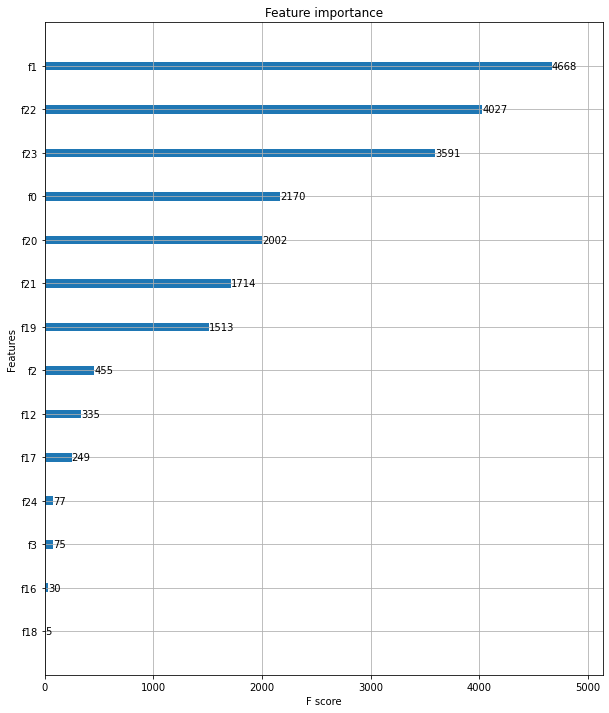

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(clf_xgb1, ax=ax)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


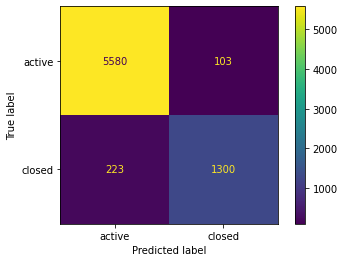

In [ ]:
plot_confusion_matrix(clf_xgb1,
                      test_input,
                      test_target,
                      values_format='d',
                      display_labels = ['active', 'closed'])

In [ ]:
#성능평가 결과값
y_pred_probs = clf_xgb1.predict(test_input)

In [ ]:
y_preds = [1 if x>0.5 else 0 for x in y_pred_probs]
print(confusion_matrix(test_target, y_preds))
print(classification_report(test_target, y_preds))
print(accuracy_score(test_target, y_preds))
print(precision_score(test_target, y_preds))
print(recall_score(test_target, y_preds))
print(f1_score(test_target, y_preds))
print(roc_auc_score(test_target, y_preds))

[[5580  103]
 [ 223 1300]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5683
           1       0.93      0.85      0.89      1523

    accuracy                           0.95      7206
   macro avg       0.94      0.92      0.93      7206
weighted avg       0.95      0.95      0.95      7206

0.9177271166993194
